In [1]:
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
import tkinter as tk

from tkinter import *
from PIL import Image, ImageDraw, ImageOps

In [2]:
class DrawingApp(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        
        self.title('Нарисуйте свою цифру')
        self.geometry('300x360')
        self.resizable(0, 0) # запрет на изменение размеров окна
        
        self.brush_size = 10 # размер кисти
        self.brush_color = 'black' # цвет кисти
        
        self.rowconfigure(2, weight=1)
        self.columnconfigure(2, weight=1)
        
        self.canvas = tk.Canvas(self, bg='white')
        self.canvas.grid(row=2, column=0, columnspan=7, padx=5, pady=5, sticky=E + W + S + N)
        self.canvas.bind('<B1-Motion>', self.draw)

        self.image_number = Image.new('L', (280, 280), 'black')
        self.draw_image = ImageDraw.Draw(self.image_number)

        self.label = tk.Label(self, text='Размер кисти: ').grid(row=0, column=0, padx=6)

        self.v = IntVar(value=10)
        self.scale = tk.Scale(self, variable=self.v, from_=5, to=20, orient=HORIZONTAL, command=self.select).grid(row=0, column=1, padx=6)

        self.button_clear = tk.Button(self, text='Очистить', width=10, command=self.clear_canvas).grid(row=1, column=0)
    
    def draw(self, event):
        x1, y1 = (event.x - self.brush_size), (event.y - self.brush_size)
        x2, y2 = (event.x + self.brush_size), (event.y + self.brush_size)

        self.canvas.create_oval(x1, y1, x2, y2, fill=self.brush_color, width=0)
        self.draw_image.ellipse((x1, y1, x2, y2), fill='white', width=0)
    
    def select(self, value):
        self.brush_size = int(value)
    
    def clear_canvas(self):
        self.canvas.delete('all')
        self.canvas['bg'] = 'white'
        self.draw_image.rectangle((0, 0, 280, 280), width=0, fill='black')
        
    def show_draw_number(self):
        drawed_image = ImageOps.contain(self.image_number, (28, 28))
        
        return drawed_image

In [3]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.i_nodes = input_nodes
        self.h_nodes = hidden_nodes
        self.o_nodes = output_nodes
        
        self.learning_rate = learning_rate
        self.activation_func = lambda x: sc.expit(x)
        
        self.w_input_hidden = np.random.rand(self.h_nodes, self.i_nodes) - 0.5
        self.w_hidden_output = np.random.rand(self.o_nodes, self.h_nodes) - 0.5
    
    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.w_input_hidden, inputs)
        hidden_outputs = self.activation_func(hidden_inputs)
        
        output_inputs = np.dot(self.w_hidden_output, hidden_outputs)
        output_signals = self.activation_func(output_inputs)
        
        output_errors = targets - output_signals
        
        hidden_errors = np.dot(self.w_hidden_output.T, output_errors)
        self.w_hidden_output += self.learning_rate * np.dot((output_errors * output_signals * 
                                                             (1.0 - output_signals)), hidden_outputs.T)
        
        self.w_input_hidden += self.learning_rate * np.dot((hidden_errors * hidden_outputs * 
                                                            (1.0 - hidden_outputs)), inputs.T)
        
    
    def query(self, input_signals):
        inputs = np.array(input_signals, ndmin=2).T
        
        hidden_inputs = np.dot(self.w_input_hidden, inputs)
        hidden_outputs = self.activation_func(hidden_inputs)
        
        output_inputs = np.dot(self.w_hidden_output, hidden_outputs)
        output_signals = self.activation_func(output_inputs)
        
        return output_signals

In [4]:
input_nodes = 784
hidden_nodes = 150
output_nodes = 10

learning_rate = 0.1

In [5]:
digit_classifier = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# Тренировка нейронной сети

In [6]:
training_dataset_file = open('mnist_dataset/mnist_train.csv', 'r')
training_dataset: list = training_dataset_file.readlines()
training_dataset_file.close()

In [7]:
from datetime import datetime
print(f'Начало обучения: {datetime.now().time()}')

# тренировка нейронной сети
# перебор всех записей в тренировочном наборе данных
epochs = 5

for i in range(epochs):
    for list_entry in training_dataset:
        character_data = list_entry.split(',')
        
        input_data = (np.asfarray(character_data[1:]) / 255.0 * 0.99) + 0.01
        target_data = np.zeros(output_nodes) + 0.01
        
        target_data[int(character_data[0])] = 0.99
        digit_classifier.train(input_data, target_data)
        
    print(f'Эпоха {i + 1} пройдена, время: {datetime.now().time()}')
    
print(f'Конец обучения: {datetime.now().time()}')

Начало обучения: 22:19:20.164935
Эпоха 1 пройдена, время: 22:20:24.016315
Эпоха 2 пройдена, время: 22:21:23.379303
Эпоха 3 пройдена, время: 22:22:22.645371
Эпоха 4 пройдена, время: 22:23:21.208839
Эпоха 5 пройдена, время: 22:24:21.932072
Конец обучения: 22:24:21.932072


# Опрос нейронной сети на всем наборе данных

In [8]:
test_dataset_file = open('mnist_dataset/mnist_test.csv', 'r')
test_dataset: list = test_dataset_file.readlines()
test_dataset_file.close()

In [9]:
evaluation_scores = [] # список оценочных баллов классификации

for record in test_dataset:
    all_values = record.split(',')
    
    correct_value = int(all_values[0])
    
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    outputs = digit_classifier.query(inputs)
    
    label = np.argmax(outputs)
    
    if (label == correct_value):
        evaluation_scores.append(1)

In [10]:
a = sum(evaluation_scores)

print(f'Корректно классифицированных изображений: {sum(evaluation_scores)}.')
print(f'В процентном соотношении: {(a / 10000 * 100):.2f}%.')

Корректно классифицированных изображений: 9690.
В процентном соотношении: 96.90%.


# Опрос нейронной сети на отдельных данных

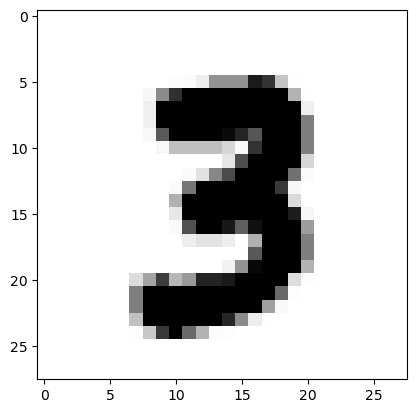

In [8]:
random_number = np.random.choice(test_dataset)

all_values = random_number.split(',')
ds_array = np.asfarray(all_values[1:]).reshape((28, 28))

plt.imshow(ds_array, cmap='Greys', interpolation='None')

In [7]:
print(f'Корректное значение: {all_values[0]}')

Корректное значение: 3


### Входные сигналы

In [218]:
input_signals = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
output_signals = digit_classifier.query(input_signals)

## Результат нейронной сети

In [220]:
for index, nums in enumerate(output_signals):
    print(f'{index} || {nums}')

0 || [0.00212264]
1 || [0.00306392]
2 || [0.00225995]
3 || [0.9993576]
4 || [0.00640806]
5 || [0.00542096]
6 || [0.00297598]
7 || [0.00026913]
8 || [0.00282733]
9 || [0.005514]


In [221]:
print(f'Результат классификации: {np.argmax(output_signals)}')

Результат классификации: 3


# Опрос нейронной сети на собственных рукописных символах

In [242]:
app = DrawingApp()
app.mainloop()
a = app.show_draw_number()

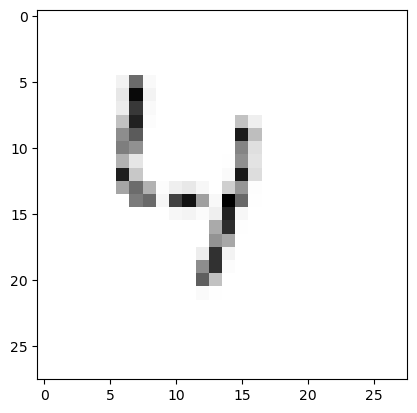

In [243]:
img = np.array(a)
plt.imshow(img, cmap='Greys', interpolation='None')

In [244]:
input_signals = (img.reshape(784,) / 255.0 * 0.99) + 0.01
output_signals = digit_classifier.query(input_signals)

In [245]:
for index, nums in enumerate(output_signals):
    print(f'{index} || {nums}')

0 || [0.00067517]
1 || [0.0165507]
2 || [0.00077685]
3 || [0.00017035]
4 || [0.51323879]
5 || [0.02793853]
6 || [0.00043876]
7 || [0.00193923]
8 || [0.00068432]
9 || [0.00210332]


In [246]:
print(f'Результат классификации: {np.argmax(output_signals)}')

Результат классификации: 4
